In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install imutils
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=90d98823b7df448602481f20dbec8ce6a9e6582baedfae555682c67a889e9c5f
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
from skimage.metrics import structural_similarity # irá ajudar a encontrar diferenças entre a imagem original e a fake
import imutils # irá ajudar a pegar o contorno das imagens
import cv2 # irá fazer a parte da visao computacional
from PIL import Image # responsavel por baixar, visualizar a imagem que iremos colocar como input
import requests # responsavel por receber dados por meio da url de requisição

In [3]:
!mkdir pan_card_tampering
!mkdir pan_card_tampering/Image

In [4]:
original = Image.open(requests.get('https://www.thestatesman.com/wp-content/uploads/2019/07/pan-card.jpg', stream=True).raw)
fake = Image.open(requests.get('https://assets1.cleartax-cdn.com/s/img/20170526124335/Pan4.png', stream=True).raw)

In [5]:
print('Original image format : ', original.format)
print('Fake image format', fake.format)

print('Original image size ', original.size)
print('Fake image size ', fake.size)

Original image format :  JPEG
Fake image format PNG
Original image size  (1200, 800)
Fake image size  (282, 179)


## Mudando o tamanho das imagens

In [6]:
original = original.resize((250,160))
print(original.size)
original.save('./pan_card_tampering/original.png')
fake = fake.resize((250,160))
fake.save('./pan_card_tampering/fake.png')
print(fake.size)

(250, 160)
(250, 160)


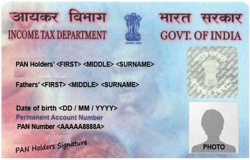

In [7]:
original

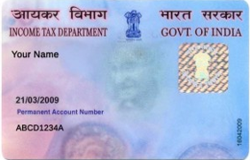

In [8]:
fake

## Lendo as imagens com OpenCV

In [10]:
# Loading images to cv2
original = cv2.imread('./pan_card_tampering/original.png')
fake = cv2.imread('./pan_card_tampering/fake.png')


# Convertendo as imagens para escala de cinza
original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
fake_gray = cv2.cvtColor(fake, cv2.COLOR_BGR2GRAY)

#### Convertendo imagens em escala de cinza usando opencv. As imagens coloridas são um pouco complexas de entender por máquina porque elas têm 3 canais enquanto a escala de cinza tem apenas 1 canal.

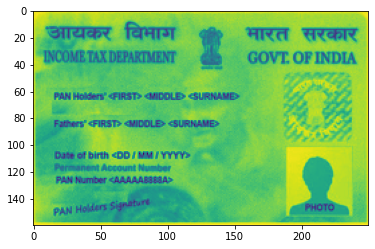

In [16]:
import matplotlib.pyplot as plt

plt.imshow(original_gray)

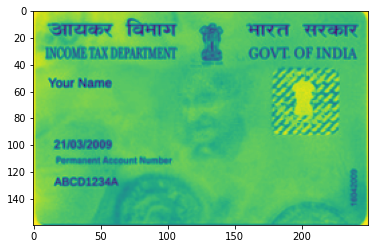

In [17]:
plt.imshow(fake_gray)

In [23]:
(score, diff) = structural_similarity(original_gray,fake_gray,full=True)
diff = (diff * 255).astype('uint8')
print(f'SSIM: {score}')
# a imgaem é 31% similar a outra

SSIM: 0.31678790332739426


#### índice de similaridade estrutural nos ajuda a determinar exatamente onde, em termos de localização das coordenadas x,y, estão as diferenças da imagem. Aqui, estamos tentando encontrar semelhanças entre a imagem original e adulterada. Quanto menor a pontuação do SSIM, menor é a similaridade.

#### Diff retorna um array com as diferenças das imagens


In [37]:
len(diff)

160

In [35]:
# encontrrando o threshold (limite da imagem)
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# RETR EXTENAL: retrieves only the extreme outer contours

# CHAIN_APPROX_SIMPLE: compresses horizontal, vertical, and diagonal segments
#and leaves only their end points.
#For example, an up-right rectangular contour is encoded with 4 points.

#### Aqui estamos usando a função de limiar da visão computacional que aplica um limiar adaptativo à imagem que é armazenada no array de formulários. Esta função transforma a imagem em tons de cinza em uma imagem binária usando uma fórmula matemática.

#### Encontrar contornos funciona na imagem binária e recuperar os contornos. Esses contornos são uma ferramenta útil para análise e reconhecimento de formas. grab_contours  pega o valor apropriado dos contornos.



In [40]:
# LOOPING nos contornos

for c in cnts:
    # aplicando o contorno calculado nas imagens
    (x,y,w,h) = cv2.boundingRect(c)
    cv2.rectangle(original, (x,y),(x + w,y +h), (0,0,255), 2)
    cv2.rectangle(fake, (x,y),(x + w,y +h), (0,0,255), 2)

#### O retângulo delimitador ajuda a encontrar a razão entre a largura e a altura do retângulo delimitador do objeto. Calculamos a caixa delimitadora do contorno e, em seguida, desenhamos a caixa delimitadora em ambas as imagens de entrada para representar onde as duas imagens são diferentes ou não.


Imagem original com contornos


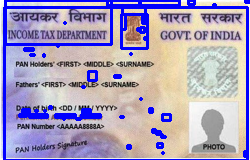

In [45]:
# vendo a imagem original com os contornos
print('Imagem original com contornos')
Image.fromarray(original)

Imagem fake com contornos


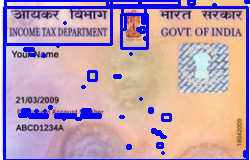

In [43]:
print('Imagem fake com contornos')
Image.fromarray(fake)

Diferença entre as imagens


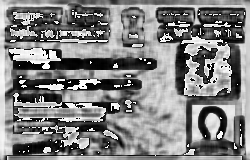

In [46]:
# Diferença em preto. toda a porção em preto marca a diferença entre as imagems

print('Diferença entre as imagens')
Image.fromarray(diff)

limite da imagem em branco


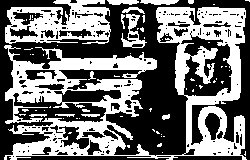

In [48]:
# visualizando o threshold de diferença entre a imagem fake e a imaem original
print('limite da imagem em branco')
Image.fromarray(thresh)

# Resumo do projeto

#### Descobrir a semelhança estrutural das imagens nos ajudou a encontrar a diferença ou semelhança na forma das imagens. Da mesma forma, descobrir o limiar e os contornos com  as imagens convertidas para binário em tons de cinza também nos ajudou na análise e reconhecimento de formas.

#### Como nosso SSIM é ~31,2%, podemos dizer que a imagem fornecida pelo usuário é falsa ou adulterada.

#### Finalmente visualizamos as diferenças e semelhanças entre as imagens usando exibindo as imagens com contornos, diferença e limiar.


# Scopo do projeto

#### Este projeto pode ser usado em diferentes organizações onde clientes ou usuários precisam fornecer qualquer tipo de ID para serem verificados. A organização pode usar este projeto para descobrir se o ID é original ou falso. Da mesma forma, isso pode ser usado para qualquer tipo de ID, como RG, titulo de eleitor, contratos, credenciais  etc.